In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
from google.colab import files
from functools import reduce

from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.signal import savgol_filter
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
files.upload()

Saving intel_preprocessed(1).csv to intel_preprocessed(1) (1).csv


{'intel_preprocessed(1).csv': b'\xef\xbb\xbfdatetime,T-1,T-2,T-3,T-4,T-6,T-7,T-9,T-10,T-11,T-21,T-22,T-23,T-24,T-25,T-26,T-27,T-29,T-31,T-32,T-33,T-34,T-35,T-36,T-37,T-38,T-39,T-40,T-41,T-42,T-43,T-44,T-45,T-46,T-47,T-48,T-51,T-52,L-1,L-2,L-3,L-4,L-6,L-7,L-9,L-10,L-11,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-29,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-51,L-52,H-1,H-2,H-3,H-4,H-6,H-7,H-9,H-10,H-11,H-21,H-22,H-23,H-24,H-25,H-26,H-27,H-29,H-31,H-32,H-33,H-34,H-35,H-36,H-37,H-38,H-39,H-40,H-41,H-42,H-43,H-44,H-45,H-46,H-47,H-48,H-51,H-52,V-1,V-2,V-3,V-4,V-6,V-7,V-9,V-10,V-11,V-21,V-22,V-23,V-24,V-25,V-26,V-27,V-29,V-31,V-32,V-33,V-34,V-35,V-36,V-37,V-38,V-39,V-40,V-41,V-42,V-43,V-44,V-45,V-46,V-47,V-48,V-51,V-52\n2004-02-28 01:00:00,19.02649230769231,19.44713846153846,19.261370666666664,19.642056470588237,19.273,19.258869767441862,18.8614,18.843251851851853,18.06327272727273,18.952292307692307,18.54600860215054,19.22666304347826,18.60533176470

In [ ]:
df= pd.read_csv('intel_preprocessed(1).csv')
df["datetime"] = pd.to_datetime(df["datetime"])



In [ ]:
df.tail()

,datetime,T-1,T-2,T-3,T-4,T-6,T-7,T-9,T-10,T-11,...,V-41,V-42,V-43,V-44,V-45,V-46,V-47,V-48,V-51,V-52
456,2004-03-20 16:00:00,25.937377,25.879439,25.915982,27.033243,122.153,24.785173,24.473031,24.457678,23.226153,...,2.469802,2.477017,2.468154,2.506130,2.481837,2.320506,2.496432,2.503431,2.451928,2.433496
457,2004-03-20 17:00:00,24.724803,24.919529,24.763524,26.141669,122.153,24.020221,23.708692,23.618937,22.581970,...,2.456822,2.458998,2.455375,2.491660,2.473541,2.317058,2.482132,2.494895,2.442580,2.426969
458,2004-03-20 18:00:00,23.733782,23.923413,23.706673,25.595163,122.153,23.167317,22.767174,22.813775,21.952632,...,2.435482,2.436169,2.437580,2.459735,2.450789,2.301371,2.457881,2.475165,2.429314,2.411871
459,2004-03-20 19:00:00,22.903667,23.211109,22.953428,25.519450,122.153,22.640350,22.079160,22.247496,21.539307,...,2.421233,2.419921,2.422563,2.439477,2.434706,2.288616,2.438821,2.463655,2.417234,2.398385
460,2004-03-20 22:00:00,21.560169,21.832012,21.719415,26.782152,122.153,21.442169,20.872150,21.117451,20.555844,...,2.394840,2.393744,2.394840,2.414039,2.413258,2.266711,2.414401,2.439110,2.393652,2.376414


In [ ]:
# Find the most correlated variable
correlation = df.corr().abs().sum().sort_values(ascending=False) # comparing and adding absolute values, so that positive and negative correlation won't cancel each oter out
correlation

H-26    88.411958
H-31    86.702594
H-27    86.152528
H-29    85.495507
H-25    85.027241
          ...    
H-6     49.217705
T-38    44.159954
L-46    41.148485
T-35    33.533759
T-6     29.429413
Length: 148, dtype: float64

In [ ]:
# Get reference values
y_ = df['H-26'].values

X = df.drop(['datetime'], axis=1).values
X_ = df.drop(['H-26'], axis=1).values



In [137]:
MAX_COMPS = 10
TEST_LEN = 1

r2s = np.zeros((7, MAX_COMPS))
q2s = np.zeros((7, MAX_COMPS))

for n_comps in range(1, MAX_COMPS + 1):
    for day in range(2, 8):
        TEST_LEN = TEST_LEN + 1 
        # Select day data
        #X_ = df[df["datetime"].dt.date == pd.to_datetime(f"2004-03")].loc[:, df.columns != "H-26"].drop(columns=["datetime"])
        X_ = df.loc[:, df.columns != "H-26"].drop(columns=["datetime"])
        Y_ = df['H-26']
        #X = X_.iloc[:48+day,] #First -x + 49 + x rows
        #Y = Y_.iloc[:48+day,]
        X = X_.iloc[:24+day,].drop(labels=range(0, day), axis=0)
        Y = Y_.iloc[:24+day,].drop(labels=range(0, day), axis=0)
        

        # Divide into train and test
        #X_train = X.iloc[:-TEST_LEN, :]
        #X_test = X.iloc[-TEST_LEN:]
        #Y_train = Y.iloc[:-TEST_LEN]
        #Y_test = Y.iloc[-TEST_LEN:]
        X_train = X.iloc[:-day, :]
        X_test = X.iloc[-day:]
        Y_train = Y.iloc[:-day]
        Y_test = Y.iloc[-day:]

        # Scale
        X_train_mean = X_train.mean()
        X_train_std = X_train.std()
        Y_train_mean = Y_train.mean()
        Y_train_std = Y_train.std()

        X_train = (X_train - X_train_mean) / X_train_std
        X_test = (X_test - X_train_mean) / X_train_std
        Y_train = (Y_train - Y_train_mean) / Y_train_std
        Y_test = (Y_test - Y_train_mean) / Y_train_std

        # Predict
        pls = PLSRegression(n_components = n_comps)
        pls.fit(X_train, Y_train)
        Y_pred = pls.predict(X_test)

        # Let's transform it to np.arrays for easier math
        Y_pred = np.array(Y_pred).squeeze()
        Y_test = np.array(Y_test)

        # R2
        r2 = r2_score(Y_test, Y_pred)
        r2s[day-1, n_comps-1] = r2

        # Q2
        TSSRes = np.sum((Y_train - Y_train.mean()) ** 2)
        PRESS = np.sum((Y_test - Y_pred) ** 2)
        q2s [day-1, n_comps-1] = 1 - PRESS / TSSRes

In [145]:
df_q2 = df_q2.drop(labels="1H", axis=0)
df_q2

,1,2,3,4,5,6,7,8,9,10
2H,0.985370,0.984661,0.990745,0.994632,0.992708,0.992290,0.993445,0.992811,0.993472,0.993839
3H,0.961703,0.956523,0.975298,0.982588,0.978442,0.978282,0.980902,0.979293,0.981235,0.982134
4H,0.925051,0.908425,0.953498,0.962142,0.954033,0.955616,0.959577,0.958143,0.959046,0.961817
5H,0.879589,0.838074,0.929415,0.932106,0.920545,0.927096,0.930858,0.932816,0.936617,0.940103
6H,0.826387,0.731302,0.880653,0.882595,0.881236,0.889180,0.892591,0.895704,0.903693,0.911704
7H,0.796008,0.571757,0.651274,0.757101,0.795688,0.817038,0.822020,0.839774,0.862588,0.874180


In [148]:
cols = [str(i) for i in range(1, MAX_COMPS + 1)]
idx = ["1H", "2H", "3H", "4H", "5H", "6H", "7H"]
df_q2 = pd.DataFrame(q2s, columns=cols, index=idx)
df_r2 = pd.DataFrame(r2s, columns=cols, index=idx)
df_q2 = df_q2.drop(labels="1H", axis=0)
df_r2 = df_r2.drop(labels="1H", axis=0)

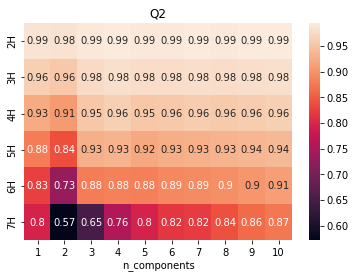

In [149]:
ax = sns.heatmap(df_q2, annot=True)
ax.set(title="Q2", xlabel="n_components")
plt.show()


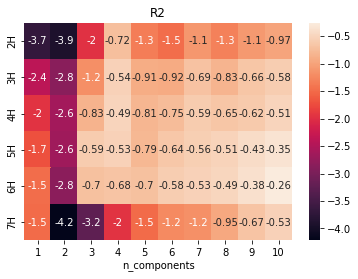

In [150]:
ax = sns.heatmap(df_r2, annot=True)
ax.set(title="R2", xlabel="n_components")
plt.show()